In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, AveragePooling2D, LSTM, Reshape,GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau ,TensorBoard
from keras import regularizers
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
from keras_preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [2]:
class_dic = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}        


In [3]:
    # Preprocess all train images
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.2
)

train_generator = train_data_gen.flow_from_directory(
        'FER-2013/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical'
)


Found 28709 images belonging to 7 classes.


In [4]:
# Preprocess all test images
validation_data_gen = ImageDataGenerator(
      rescale=1./255,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.2
)

validation_generator = validation_data_gen.flow_from_directory(
        'FER-2013/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [5]:
from collections import Counter
train_counter = Counter(train_generator.classes)
val_counter = Counter(validation_generator.classes)

print(train_counter.items())
print(val_counter.items())

dict_items([(0, 3995), (1, 436), (2, 4097), (3, 7215), (4, 4965), (5, 4830), (6, 3171)])
dict_items([(0, 958), (1, 111), (2, 1024), (3, 1774), (4, 1233), (5, 1247), (6, 831)])


In [6]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Get the class labels from the generator
train_labels = train_generator.classes
validation_labels = validation_generator.classes

# Compute the class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)

# Convert the class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


### Model Architecture

In [7]:
from tensorflow.keras import layers

def create_vision_transformer_model(input_shape, num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    # Convolutional Block 0
    x = layers.Conv2D(32, kernel_size=2, activation='relu', padding='same')(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Block 1
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

     # Reshape and Transformer
    x = layers.MultiHeadAttention(num_heads=8, key_dim=8)(x, x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization()(x)

    # Convolutional Block 2
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)
    
    # Convolutional Block 2
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)

    # Reshape and Transformer
    x = layers.Reshape((-1, 128))(x)
    x = layers.MultiHeadAttention(num_heads=8, key_dim=8)(x, x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    keras.utils.plot_model(model, to_file = "TransformerVariation.png", show_shapes = True, show_dtype = True)

    return model

# Create the Vision Transformer model
input_shape = (48, 48, 1)
model = create_vision_transformer_model(input_shape, num_classes=7)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   160         ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 48, 48, 32)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 32)   0           ['layer_normalization[0][0]']

In [9]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1
)

Earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose =1,
)

TensBoard = TensorBoard(
    log_dir = 'logs-TransformerClassWeight'
)

checkpoint = ModelCheckpoint(
    filepath = 'TransformerClassWeight.h5',
    verbose = 1,
    save_best_only = True
)

In [10]:
epochs = 100
adam = keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the neural network/model
history = model.fit(
        train_generator,
        epochs = 100,
        validation_data = validation_generator,
        callbacks= [lr_reduce, Earlystop, TensBoard, checkpoint],
        class_weight=class_weights_dict
)

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.9853 - accuracy: 0.1243
Epoch 1: val_loss improved from inf to 1.91140, saving model to TransformerClassWeight.h5
449/449 [==============================] - 288s 631ms/step - loss: 1.9853 - accuracy: 0.1243 - val_loss: 1.9114 - val_accuracy: 0.1718 - lr: 0.0020
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.9590 - accuracy: 0.1256
Epoch 2: val_loss did not improve from 1.91140
449/449 [==============================] - 276s 614ms/step - loss: 1.9590 - accuracy: 0.1256 - val_loss: 1.9819 - val_accuracy: 0.0155 - lr: 0.0020
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.9578 - accuracy: 0.1182
Epoch 3: val_loss did not improve from 1.91140
449/449 [==============================] - 282s 628ms/step - loss: 1.9578 - accuracy: 0.1182 - val_loss: 1.9322 - val_accuracy: 0.1718 - lr: 0.0020
Epoch 4/100
449/449 [==============================] - ETA: 0s - loss: 1.9532 - a

### Accuracy & Loss plots

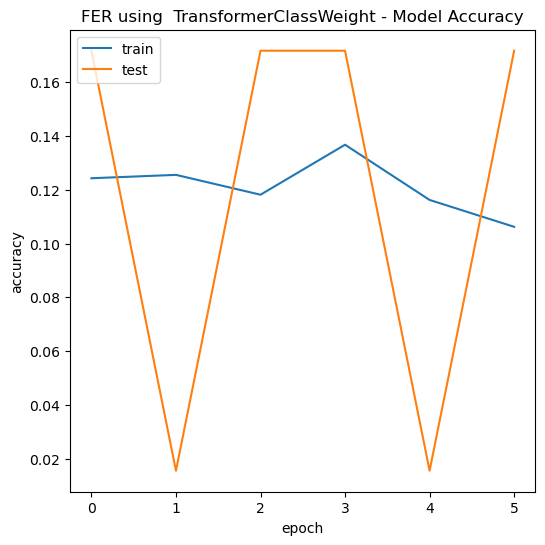

In [12]:
acc = plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('FER using  TransformerClassWeight - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
acc.savefig("ACC-TransformerClassWeight")
plt.show()


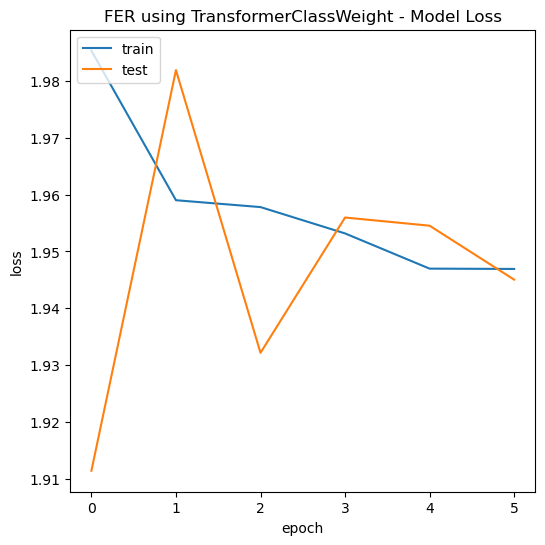

In [13]:
loss = plt.figure(figsize = (6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('FER using TransformerClassWeight - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
loss.savefig("LOSS-TransformerClassWeight")
plt.show()

In [14]:
prediction = model.predict(validation_generator)

113/113 [==============================] - 25s 216ms/step


In [15]:
loss, accuracy = model.evaluate(validation_generator, 
                                verbose=0)     

print("Accuracy of our model on validation data : ", accuracy*100, "%")
print("Accuracy of our model on validation data : ", loss)

Accuracy of our model on validation data :  17.177486419677734 %
Accuracy of our model on validation data :  1.9450387954711914


### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.00      0.00      0.00      1774
           4       0.17      1.00      0.29      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.17      7178
   macro avg       0.02      0.14      0.04      7178
weighted avg       0.03      0.17      0.05      7178



c:\Users\moham\miniconda3\envs\minimal_ds\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\moham\miniconda3\envs\minimal_ds\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\moham\miniconda3\envs\minimal_ds\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


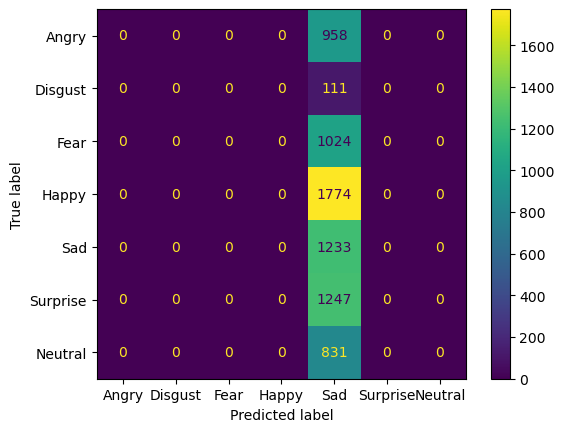

In [16]:
# Classification report
print(classification_report(validation_generator.classes, prediction.argmax(axis=1)))

# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, prediction.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=class_dic.values())
cm_display.plot()